In [1]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torchvision.models import resnet18

model = resnet18()
model.fc = nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load('model.pt'))
model = model.cuda()

original_worm = np.array(Image.open("worm.png"))
original_worm_x = torch.tensor(original_worm.transpose(2, 0, 1) / 255.0, dtype=torch.float32).unsqueeze(0).cuda()
original_worm_y = float(torch.sigmoid(model(original_worm_x)))
print(original_worm_y, original_worm_y < 0.5)

0.5788716077804565 False


In [2]:
def pipeline(inp):
    x = torch.tensor(inp.transpose(2, 0, 1) / 255.0, dtype=torch.float32).unsqueeze(0).cuda()
    x.requires_grad = True
    model.zero_grad()
    loss = torch.sigmoid(model(x)).sum()
    (-loss).backward()
    return float(loss), x.grad[0].cpu().numpy().transpose(1, 2, 0)
assert pipeline(original_worm)[0] == original_worm_y

def optimize(img, px_to_modify, lr_schedule):
    mask = np.zeros((224 * 224, 3))
    mask[px_to_modify] = np.ones(3)
    mask = mask.reshape((224, 224, 3))

    img = img.copy()
    for lr in lr_schedule:
        y, grad = pipeline(img)
        img = img + (grad * mask) * lr
        img = img.clip(0, 255)
    return y, img

In [3]:
from random import seed, randrange

# guesstimated parameters
SEED = 1116
SHORT_LR = np.logspace(4, 3, num=15)
LONG_LR = np.logspace(4, 2, num=60)
VERY_LONG_LR = np.logspace(4, 2, num=500)
TRIALS = 30

not_worm = original_worm.copy()
current_pixels = []

seed(SEED)
while len(current_pixels) < 30:
    candidate_pixels = []
    for _ in range(TRIALS):
        while True:
            candidate_pixel = randrange(0, 224 * 224)
            if candidate_pixel not in current_pixels:
                break
        y, _ = optimize(not_worm, current_pixels + [candidate_pixel], SHORT_LR)
        candidate_pixels.append((y, candidate_pixel))
    
    _, next_pixel = min(candidate_pixels)
    current_pixels.append(next_pixel)
    y, not_worm = optimize(not_worm, current_pixels, LONG_LR)
    print(f"Step {len(current_pixels): >2}: next_pixel = {next_pixel: >5} y = {y:.4f}")

y, not_worm = optimize(not_worm, current_pixels, VERY_LONG_LR)
print(f"Final y = {y:.4f}")
assert y < 0.5

not_worm_uint8 = not_worm.astype(np.uint8)
y = pipeline(not_worm_uint8)[0]
print(f"u8 image y = {y:.4f}")
assert y < 0.5

Step  1: next_pixel = 39814 y = 0.5681
Step  2: next_pixel = 31882 y = 0.5622
Step  3: next_pixel = 34264 y = 0.5553
Step  4: next_pixel =  9103 y = 0.5493
Step  5: next_pixel = 14606 y = 0.5451
Step  6: next_pixel = 43108 y = 0.5422
Step  7: next_pixel = 35676 y = 0.5408
Step  8: next_pixel = 11388 y = 0.5381
Step  9: next_pixel = 34464 y = 0.5353
Step 10: next_pixel = 34009 y = 0.5373
Step 11: next_pixel = 18554 y = 0.5326
Step 12: next_pixel = 38401 y = 0.5292
Step 13: next_pixel =  6125 y = 0.5259
Step 14: next_pixel = 35782 y = 0.5243
Step 15: next_pixel = 45768 y = 0.5226
Step 16: next_pixel = 27687 y = 0.5212
Step 17: next_pixel = 13967 y = 0.5175
Step 18: next_pixel = 34110 y = 0.5126
Step 19: next_pixel = 49632 y = 0.5092
Step 20: next_pixel = 36196 y = 0.5062
Step 21: next_pixel =  2242 y = 0.5007
Step 22: next_pixel = 23979 y = 0.4977
Step 23: next_pixel = 45967 y = 0.4963
Step 24: next_pixel =  6436 y = 0.4964
Step 25: next_pixel = 43330 y = 0.4935
Step 26: next_pixel = 307

In [4]:
changed = np.where((not_worm_uint8 - original_worm))
changed_px = list(sorted(set(zip(changed[0], changed[1]))))
assert len(changed_px) <= 30

payload = []
for y, x in changed_px:
    r, g, b = not_worm_uint8[y, x]
    packet = f"{x},{y},{r},{g},{b}"
    payload.append(packet)
payload = ";".join(payload)
print(payload)

2,10,255,141,45;77,27,0,0,0;164,28,0,21,136;143,40,245,120,0;200,48,0,0,59;188,50,252,0,0;79,62,0,36,14;46,65,88,157,9;186,82,0,14,127;154,94,135,41,191;11,107,75,45,0;135,123,21,144,57;56,137,0,4,42;74,142,129,59,47;90,145,67,0,126;185,151,69,255,36;62,152,86,0,255;216,152,0,255,31;192,153,68,177,20;60,159,255,248,255;124,159,92,98,84;166,159,176,18,133;132,161,145,130,25;97,171,255,0,1;166,177,255,255,222;100,192,255,114,42;98,193,255,114,153;72,204,0,255,255;47,205,19,255,27;128,221,201,44,255


In [5]:
from pwn import remote
from subprocess import check_output

!wget https://pwn.red/pow -O pow.sh -q

io = remote("challs.umdctf.io", 31774)
io.recvline()
pow_chal = io.recvline().strip()
# my ml environment's LD_PRELOAD messes with curl :smiling_face_with_tear:
pow_chal = pow_chal.replace(b"curl -sSfL https://pwn.red/pow", b"cat pow.sh")
pow_result = check_output(pow_chal, shell=True)
io.send(pow_result)
io.sendline(payload.encode())
print(io.recvuntil(b"}").decode())

[x] Opening connection to challs.umdctf.io on port 31774
[x] Opening connection to challs.umdctf.io on port 31774: Trying 45.79.181.160
[+] Opening connection to challs.umdctf.io on port 31774: Done
solution: Enter a list of pixels to change, in the format 'x,y,r,g,b;x,y,r,g,b;...':
LISAN AL GAIB
UMDCTF{spice_harvester_destroyed_sunglasses_emoji}


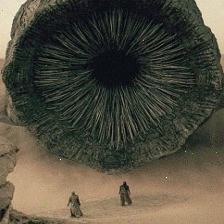

In [9]:
im = Image.fromarray(not_worm_uint8)
im.save("not_worm.png")
im

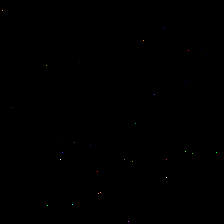

In [24]:
not_worm_diff = np.zeros_like(not_worm.astype(np.uint8))
for y, x in changed_px:
    not_worm_diff[y, x] = not_worm[y, x]

im = Image.fromarray(not_worm_diff)
im.save("not_worm_diff.png")
im